Plot figures 3, 4, S3, S4

In [1]:
%matplotlib inline

In [2]:
import sys
import os
import argparse
import dill
import pickle
import scipy
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import xesmf as xe
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import regionmask as rm

from global_land_mask import globe
from shapely.geometry import Point
from matplotlib.colors import BoundaryNorm

from dataa.d_config import lat_res, lon_res
from cmip6.treat_data.get_valid_models import load_valid_models
from cmip6.ns_gev.future.all_mems.fit_nsgev_freexi_future_all_mems_rversion_extRemes import load_nsgev_params_freexi_cmip_future_all_mems
from cmip6.fdt.point.compute_drr_analytically import load_analytical_drr
from cmip6.fdt.fdt_config import DATADIR, FIGDIR

Done
Done


R[write to console]: Loading required package: Lmoments

R[write to console]: Loading required package: distillery

R[write to console]: 
Attaching package: ‘extRemes’


R[write to console]: The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




CANNOT IMPORT ISMEVs
R sink error
Done


In [3]:
### CST ###

cmap = 'plasma'  # 'viridis'  #   'inferno'
dbffile = './dataa/shapefiles/referenceRegions/referenceRegions.dbf'
cnydbffile = './dataa/shapefiles/World_Continents/World_Continents.dbf'   # ./dataa/world-boundaries/world-administrative-boundaries.dbf'
grid_step = 2.5  # horizontal resolution of new grid (grid_step x grid_step)
ts0 = np.arange(10., 100.+10, 10)

In [4]:
### FUNC ###

def add_matrix_NaNs(regridder):
    # Add NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder


def load_regridded_analytical_drr(ds='CMIP6', source='CanESM5', ssp_exp='ssp245', grid_step=2.5, params=['loc', 'scale'], ymin=1950, ymax=2100, yref=2020, nmems=10, rrf=2., ndays=None):
    """Load regridded DRR data"""
    res_all = str(grid_step) + 'x' + str(grid_step)
    params_ = "-".join(params)

    if nd:
        nd_ = '_' + str(nd) + 'd'
    else:
        nd_ = ''

    outdir = DATADIR + '/maps/' + ds + '/drr_regridded/' + ssp_exp + '/' + res_all + '/' + params_ + '/FDT'
    outfile = outdir + '/global_drr_' + source + '_' + str(ymin) + '-' + str(ymax) + '_yref=' + str(yref) + '_N=' + str(nmems) + '_rrf=' + str(rrf) + nd_ + '.nc'

    out = xr.open_dataarray(outfile)

    return out

In [5]:
#~ Get script parameters

ds = 'CMIP6'
srcs = ['ACCESS-ESM1-5', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-LR']
ssp_exp = 'ssp245'
nmems = 10
params = ['loc', 'scale']
lat_sub = (-90., 90.)
lon_sub = (-180., 180.)
ymin = 1950
ymax = 2100
yref = 2020
rrf = 2.
t0_2plot = 100
nd = None  # RX1D / RX7D
q_inf = 0.05  # lower bound of the trends range
q_sup = 0.95  # upper bound of the trends range
nvals = 2  # number of valid models


qs_ = str(q_inf*100) + '-' + str(q_sup*100)
params_ = "-".join(params)

lat_min_ = lat_sub[0]
lat_max_ = lat_sub[1]
lon_min_ = lon_sub[0]
lon_max_ = lon_sub[1]

domain = '({0},{1})'.format(lat_min_, lat_max_) + '_({0},{1})'.format(lon_min_, lon_max_)

if lat_max_ - lat_min_ == 20:
    lat_step = 20.
elif lat_max_ - lat_min_ == 180:
    lat_step = 30.

if lon_max_ - lon_min_ == 40:
    lon_step = 20.
elif lon_max_ - lon_min_ == 360:
    lon_step = 60.

yrs_spec = str(ymin) + '-' + str(ymax)

years = np.arange(ymin, ymax+1, 1)
iyref = np.where(years == yref)[0][0]

if nd:
    nd_ = '_' + str(nd) + 'd'
    nd__ = str(nd)
else:
    nd_ = ''
    nd__ = '1'


#~ Plot params

cmap = plt.get_cmap(cmap)
cmap.set_under(color='grey', alpha=0.975)
cmap.set_over(color='grey', alpha=0.25)
cmap_fail = plt.cm.get_cmap('Greys')

ncols = [0., 10., 20., 30., 40., 50., 60., 70., 80.]  # np.arange(0, len(years[iyref:]), 10)   # np.linspace(-d_max, d_max, 41)
norm = BoundaryNorm(ncols, ncolors=cmap.N) #, clip=True)

xtcks = np.arange(-120., 120+60., 60.)  # lon_min_, lon_max_+lon_step, lon_step)
ytcks = np.arange(-60., 60.+30., 30.)  # lat_min_, lat_max_+lat_step, lat_step)

ts2plot = str(t0_2plot/rrf) + '.' + str(t0_2plot)

In [6]:
vals_models = load_valid_models(ds=ds, ssp_exp=ssp_exp, grid_step=grid_step, ndays=nd, q_inf=q_inf, q_sup=q_sup)
vals_regs = vals_models.sum(axis=1)
vals_regs = vals_regs[vals_regs >= nvals]
vals_models = vals_models.loc[vals_regs.index]

df = gpd.read_file(dbffile)
dfcny = gpd.read_file(cnydbffile)

ar6regs = rm.defined_regions.ar6.df[:43]
reg2plot = ar6regs['Name'].values

xlbs = [ar6regs[ar6regs['Name'] == reg]['Acronym'].values[0] for reg in reg2plot]

res_all = str(grid_step) + 'x' + str(grid_step)
ds_out = xe.util.grid_global(grid_step, grid_step)

classes = [[1, 20], [21, 40], [41, 60], [61, 80], [81, 150000000], [-10000000, 0]]
pielbs = ["-".join([str(clas) for clas in classe]) for classe in classes[:-2]] + ['$>$ 80'] + ['$<$ 0 trend']

In [7]:
out_drrs = []

for src in srcs:
    print(src, end=' : ', flush=True)

    drrs = load_regridded_analytical_drr(ds, src, ssp_exp, grid_step, params, ymin, ymax, yref, nmems, rrf, nd)
    out_drrs.append(drrs)

out_drrs = xr.concat(out_drrs, dim='GCM')
out_drrs_mean = out_drrs.mean(dim='GCM', skipna=True)   # TEST SKIPNA

lats_LR = out_drrs_mean.lat
lons_LR = out_drrs_mean.lon

mask_land = rm.defined_regions.ar6.land.mask(lons_LR, lats_LR)  # AR6 regions mask
mask_ocean = globe.is_ocean(mask_land.lat, mask_land.lon)   # Ocean mask: True (masked) if point is ocean

mask_land_ = np.ma.array(mask_land, mask=mask_ocean)  # AR6 regions land points
n_land = len(mask_land_.mask[mask_land_.mask == False])   # number of land grid points

ACCESS-ESM1-5 : CanESM5 : IPSL-CM6A-LR : MIROC6 : MPI-ESM1-2-LR : 


-- Plot map --
Greenland/Iceland : 116 116
N.W.North-America : 149 149
N.E.North-America : 138 138
C.North-America : 47 47
E.North-America : 57 57
N.Central-America : 32 32
S.Central-America : 13 13
N.E.South-America : 35 35
S.W.South-America : 16 16
S.South-America : 13 13
West&Central-Europe : 69 69
Mediterranean : 65 65
Western-Africa : 43 43
S.Eastern-Africa : 28 28
Madagascar : 8 8
Russian-Arctic : 165 165
E.Siberia : 128 128
Russian-Far-East : 66 66
W.C.Asia : 89 89
Tibetan-Plateau : 38 38
S.Asia : 59 59
N.Australia : 20 20
C.Australia : 50 50
E.Australia : 16 16
S.Australia : 24 24


<ipython-input-8-41773206c765>:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_bar.show()


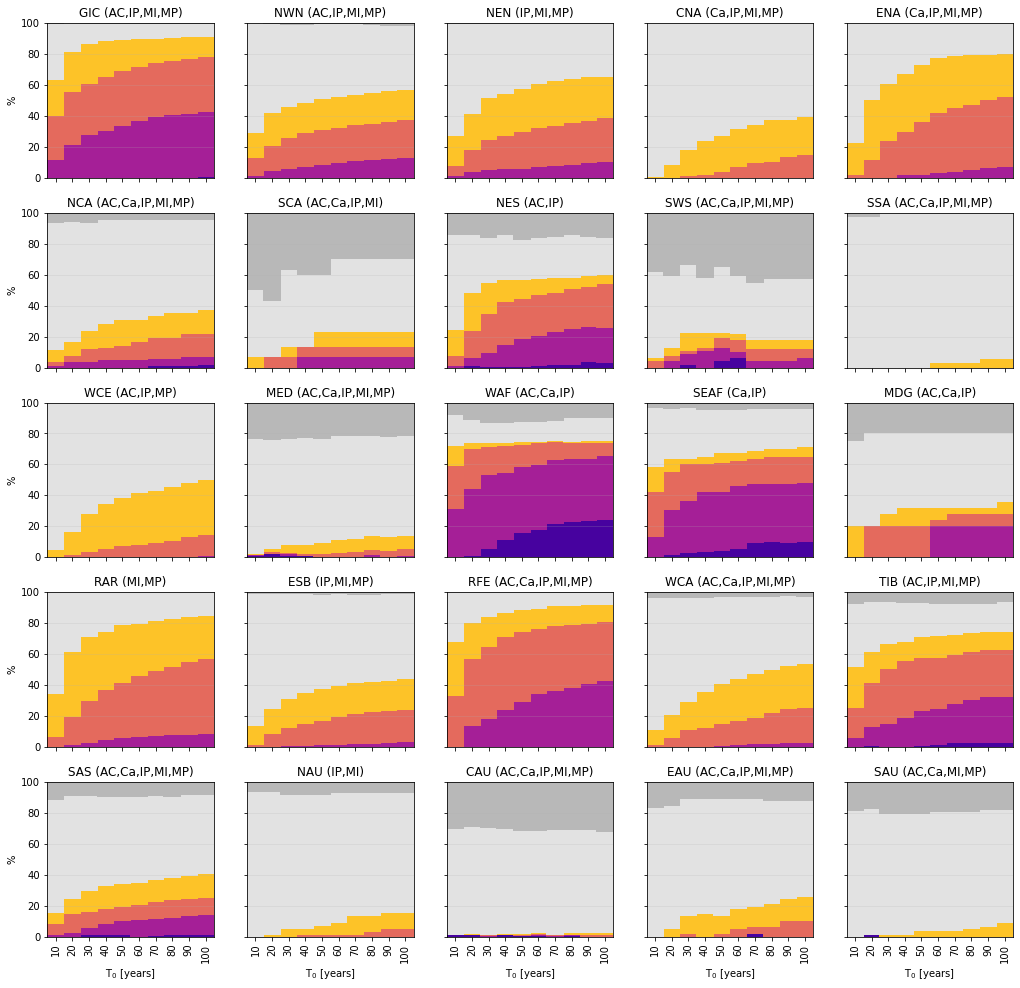

In [8]:
#~ Plot

lons_ = lons_LR - grid_step / 2
lats_ = lats_LR - grid_step / 2

reg2plot_ = ar6regs['Name']  # .drop([7, 15, 27, 39, 41], axis=0)['Name']   FOR TEST

drrs_regs = {}
drrs_regs_classes_mean = {}

if nd:
    fig_bar, ax_bar = plt.subplots(nrows=6, ncols=4)
else:
    fig_bar, ax_bar = plt.subplots(nrows=5, ncols=5)

plt.subplots_adjust(left=0.05, right=0.975, bottom=0.1, top=0.975, hspace=0.225)

xtlbs = [int(t) for t in ts0]
ytcks_bar = np.arange(0, 100+20, 20)
ytlbs_bar = ytcks_bar

normcols = mpl.colors.Normalize(vmin=1, vmax=80)
classes_center = [int((clas[1] - clas[0])/2 + clas[0]) for clas in classes[:-2]]
rgbacols = [cmap(normcols(cent), bytes=True) for cent in classes_center]
hexcols = ['#%02x%02x%02x' % (rgbacol[0], rgbacol[1], rgbacol[2]) for rgbacol in rgbacols]

rgbalower = cmap_fail(99, bytes=True)
hexcollower = '#%02x%02x%02x' % (rgbalower[0], rgbalower[1], rgbalower[2])
rgbaupper = cmap_fail(50, bytes=True)
hexcolupper = '#%02x%02x%02x' % (rgbaupper[0], rgbaupper[1], rgbaupper[2])
hexcols = hexcols + [hexcolupper] + [hexcollower]

i = 0
j = 0

out_prop_regs_min = {}
out_prop_regs = {}
out_prop_regs_max = {}
prop_tot = []
plotted_regs = []
acronyms = []

for reg in vals_regs.index:
    print(reg, end=' : ', flush=True)

    ireg = ar6regs[ar6regs['Name'] == reg].index[0]
    acronym = ar6regs[ar6regs['Name'] == reg]['Acronym'][ireg]  # + ' ({0}%)'.format(round(prop_n_land_reg, 1))

    mask_reg = np.ma.masked_not_equal(mask_land_, ireg)  # Land grid points in AR6 region
    n_land_reg = len(mask_reg.mask[mask_reg.mask == False])

    print(len(np.where(mask_land_ == ireg)[1]), n_land_reg)

    prop_n_land_reg = n_land_reg / n_land * 100
    prop_tot.append(n_land_reg)  # prop_n_land_reg

    vals_models_reg = vals_models.loc[reg]
    vals_srcs = list(vals_models_reg[vals_models_reg == 1].index)

    if vals_srcs != []:
        lab = ','.join(v for v in [val[0:2] for val in vals_srcs])
        df_reg_srcs = []

        for isrc, src in enumerate(srcs):
            df_src = pd.DataFrame(index=ts0, columns=pielbs)

            for t0 in ts0:
                out_drrs_src = out_drrs.sel(ts0=t0).isel(GCM=isrc)

                masked_drrs = np.ma.array(out_drrs_src, mask=mask_reg.mask)
                drrs_reg = masked_drrs[~masked_drrs.mask].data.flatten()

                df = pd.DataFrame(data=drrs_reg, columns=['val']).dropna().round(0)

                if len(df) != 0:
                    prop_classes = [len(df.query('{0} <= val <= {1}'.format(classe[0], classe[1])).values) / len(df) * 100 for classe in classes]
                    df_src.loc[t0] = prop_classes

                else:
                    print('{0}: NO {1} DATA'.format(reg, t0))

            df_reg_srcs.append(df_src)

        df_reg_srcs = pd.concat(df_reg_srcs)
        df_reg_min = df_reg_srcs.groupby(df_reg_srcs.index).apply(lambda x: x.min())
        df_reg_mean = df_reg_srcs.groupby(df_reg_srcs.index).apply(lambda x: x.mean())
        df_reg_max = df_reg_srcs.groupby(df_reg_srcs.index).apply(lambda x: x.max())
        acronyms.append(acronym)

        if len(df_reg_mean.dropna()) != 0:
            drrs_regs_classes_mean[reg] = df_reg_mean.loc[t0_2plot].values

            if j == len(ax_bar[1]):
                j=0
                i=i+1

            ax_ = ax_bar[i][j]

            df_reg_mean.plot.bar(ax=ax_, color=hexcols, stacked=True, width=1.05, legend=False)

            ax_.set_xticklabels([])
            ax_.set_xlim(-0.5, 9.5)
            ax_.set_yticks(ytcks_bar)
            ax_.set_yticklabels([])
            ax_.set_ylim(0., 100.)
            ax_.grid(True, axis='y', alpha=0.25)

            if j == 0:
                ax_.set_yticklabels(ytlbs_bar)
                ax_.set_ylabel('%')
            if i == ax_bar.shape[0]-1:
                ax_.set_xticklabels(xtlbs)
                ax_.set_xlabel('T$_0$ [years]')

            ax_.set_title('%s (%s)'%(acronym, lab))

            j=j+1
            plotted_regs.append(reg)

            out_prop_regs_min[reg] = df_reg_min
            out_prop_regs[reg] = df_reg_mean
            out_prop_regs_max[reg] = df_reg_max

        else:
            print('{0}: NO DATA AT ALL'.format(reg, t0))

    else:
        print('NO VALID MODEL FOR %s'%reg)

if nd == 7:
    fig_bar.set_size_inches(10.5, 15.)
else:
    fig_bar.set_size_inches(14.5, 14.5)

fig_bar.show()

In [9]:
#~ Get regional FDT values (Tables S2 and S3)

tab = pd.concat(out_prop_regs.values())
tab_ = tab.loc[t0_2plot]
tab_.index = out_prop_regs.keys()
tab_ = tab_.astype(float).round(1)
mean_prop = tab_.mean(axis=0)

#tabfile = outdir + '/global_drr_t0=' + str(t0_2plot) + '_rrf=' + str(rrf) + nd_
#tab_.to_latex(tabfile)

tab_minmax = pd.DataFrame(index=tab_.index, columns=tab_.columns)

for reg in tab_minmax.index:
    for iclss, clss in enumerate(tab_minmax.columns):
        tab_minmax.loc[reg][clss] = '{0} [{1};{2}]'.format(out_prop_regs[reg][clss].loc[t0_2plot].astype(float).round(1), out_prop_regs_min[reg][clss].loc[t0_2plot].astype(float).round(1), out_prop_regs_max[reg][clss].loc[t0_2plot].astype(float).round(1))

tab_minmax.index = acronyms

tab_minmax

,1-20,21-40,41-60,61-80,$>$ 80,$<$ 0 trend
GIC,0.6 [0.0;2.9],42.1 [3.7;97.1],35.8 [0.0;59.8],13.0 [0.0;29.3],8.4 [0.0;31.7],0.2 [0.0;1.2]
NWN,0.0 [0.0;0.0],13.1 [0.0;26.3],24.3 [19.2;31.0],19.2 [7.8;30.5],41.8 [18.9;61.3],1.6 [0.0;4.5]
NEN,0.0 [0.0;0.0],10.6 [1.5;32.3],28.0 [18.5;42.3],27.0 [17.9;35.1],34.2 [24.6;50.8],0.3 [0.0;1.3]
CNA,0.0 [0.0;0.0],0.0 [0.0;0.0],15.0 [2.2;28.3],24.7 [10.9;43.5],60.3 [28.3;80.4],0.0 [0.0;0.0]
ENA,0.0 [0.0;0.0],7.4 [0.0;26.2],45.2 [16.3;66.7],27.8 [4.8;37.5],19.6 [0.0;59.2],0.0 [0.0;0.0]
NCA,1.9 [0.0;9.5],4.7 [0.0;19.0],15.3 [0.0;40.9],15.2 [0.0;27.3],58.2 [27.3;77.3],4.8 [0.0;23.8]
SCA,0.0 [0.0;0.0],6.7 [0.0;33.3],6.7 [0.0;33.3],10.0 [0.0;50.0],46.7 [0.0;100.0],30.0 [0.0;100.0]
NES,2.8 [0.0;13.8],22.8 [3.2;58.3],28.4 [15.6;67.7],6.1 [3.4;9.7],23.9 [9.7;31.2],16.0 [0.0;37.9]
SWS,0.0 [0.0;0.0],6.0 [0.0;20.0],6.0 [0.0;20.0],5.8 [0.0;20.0],39.2 [0.0;85.7],43.0 [14.3;63.6]
SSA,0.0 [0.0;0.0],0.0 [0.0;0.0],0.0 [0.0;0.0],5.7 [0.0;28.6],94.3 [71.4;100.0],0.0 [0.0;0.0]
